<a href="https://colab.research.google.com/github/Brijeshtanwar/Topic-Modeling/blob/main/sklearn_nlp_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.6 MB/s eta 0:00:00


In [3]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

In [21]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [7]:
url = """https://raw.githubusercontent.com/Brijeshtanwar/Topic-Modeling/main/voc_data.csv"""
df = pd.read_csv(url,  encoding = 'unicode_escape')

In [8]:
df = df[['CUSTOMER COMMENT', 'Reason']]
df.columns = ['comment', 'topic']

In [9]:
df.isnull().sum()

comment    0
topic      0
dtype: int64

In [10]:
# Drop na 
df.dropna(axis=0, inplace=True)

In [11]:
df.topic.value_counts()

Service                      1570
APPLICATION (WEB/APP)        1074
SERVICE                       335
CHARGES(BRO./DP/LPC ETC.)     332
Others                        321
NOT SPECIFIED                 254
Not Specified                 216
People                        113
Process                        69
PEOPLE                         32
Product                        13
PROCESS                         6
Name: topic, dtype: int64

In [12]:
#lower case
df['topic'] = df['topic'].str.lower()
df['topic'] = df['topic'].str.strip()
df.loc[df.topic=='not specified', 'topic'] = 'others'

In [13]:
df.topic.unique()

array(['service', 'application (web/app)', 'others',
       'charges(bro./dp/lpc etc.)', 'process', 'people', 'product'],
      dtype=object)

In [14]:
topic_dic = {'application (web/app)': 'application',  'charges(bro./dp/lpc etc.)': 'charges', 'service':'service'
, 'others':'others', 'process':'process', 'people':'people', 'product':'product'}

In [15]:
df['topic'] = df['topic'].map(topic_dic)

<Axes: xlabel='count', ylabel='topic'>

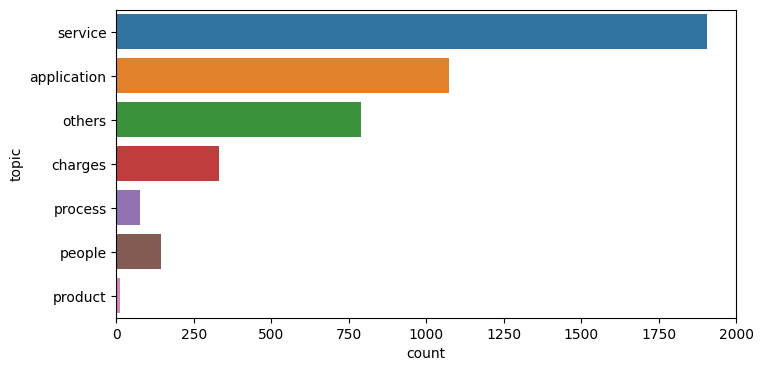

In [22]:
plt.figure(figsize=[8,4])
sns.countplot(y=df['topic'])

In [23]:
# Preprocessing

In [24]:
# Remove integer comments
df = df[df['comment'].apply(lambda x: not isinstance(x, int))]
df.reset_index(drop=True, inplace=True)

#lower case
df['comment'] = df['comment'].str.lower()

In [32]:
import re

In [33]:
def preprocess_text(text):
    ## clean (convert to lowercase and remove punctuations and  characters and then strip)
    text = re.sub(r"[^A-Za-z]+", ' ' , str(text).lower().strip())
    return text

In [34]:
df["x"] = df["comment"].apply(lambda x: preprocess_text(x))
# df['x'] = df['comment']
df['y'] = df['topic']
df.head(10)

,comment,topic,x,y
0,querries where kotak is at disadvantageous pos...,service,querries where kotak is at disadvantageous pos...,service
1,1) same-day money deduction even if we have ma...,application,same day money deduction even if we have margi...,application
2,ndejjejdjx,others,ndejjejdjx,others
3,worst website trading,application,worst website trading,application
4,"no technical support at real time, application...",service,no technical support at real time application ...,service
5,need knowledge and experience person,service,need knowledge and experience person,service
6,please revisit my brokerage and deemat charges...,charges,please revisit my brokerage and deemat charges...,charges
7,iâm waiting for resolution or a meeting with...,service,i m waiting for resolution or a meeting with m...,service
8,i dint interacted so my rating may be a bias b...,service,i dint interacted so my rating may be a bias b...,service
9,no issues with the rm,service,no issues with the rm,service


In [35]:
df = df[['x', 'y']]

In [37]:
# Dict for classes
df['category_id'] = df['y'].factorize()[0]
category_id_df = df[['y', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'y']].values)

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.category_id.values, 
                                                  test_size=0.20, 
                                                  random_state=42, 
                                                  stratify=df.category_id.values)

In [42]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [48]:
df.columns = ['Title', 'Conference', 'label', 'data_type']

In [46]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [49]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].Title.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].Title.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [53]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [54]:
len(dataset_train), len(dataset_val)

(3468, 867)

In [59]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=df.label.nunique(),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [60]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [61]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [62]:
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [63]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [64]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cpu


In [66]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'data_volume/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1156 [00:00<?, ?it/s]

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)


In [ ]:
model.load_state_dict(torch.load('data_volume/finetuned_BERT_epoch_1.model', map_location=torch.device('cpu')))

In [ ]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [ ]:
accuracy_per_class(predictions, true_vals)

In [ ]:

df_train, df_test = train_test_split(df, test_size=0.30, stratify=df['y'], random_state=324)

In [ ]:
df_test_pred['category_id'] = df_test_pred['y'].map(category_to_id) 
df_test_pred['category_id_pred'] = df_test_pred['y_pred'].map(category_to_id) 
df_pred['category_id_pred'] = df_pred['y_pred'].map(category_to_id) 

In [ ]:
df_test_pred[df_test_pred['category_id_pred'].isnull()]

,x,y,y_pred,category_id,category_id_pred


In [ ]:
df_test_pred.y_pred.unique()

array(['service', 'application', 'charges', 'others', 'people', 'process'],
      dtype=object)

<Axes: >

Text(33.222222222222214, 0.5, 'Actual')

Text(0.5, 25.722222222222214, 'Predicted')

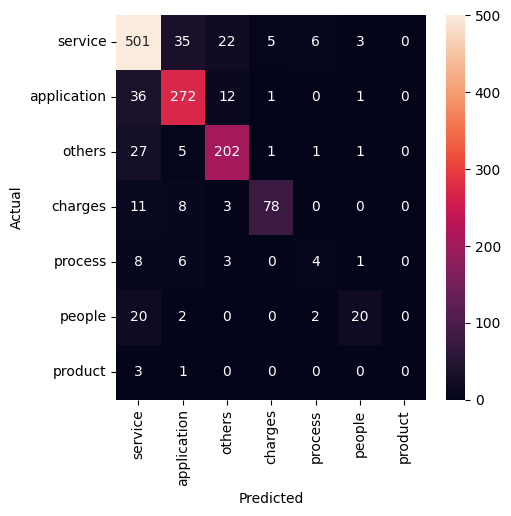

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(df_test_pred['category_id'], df_test_pred['category_id_pred'])
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.y.values, yticklabels=category_id_df.y.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Classification report
from sklearn import metrics
print(metrics.classification_report(df_test_pred['category_id'], df_test_pred['category_id_pred'], target_names=df['y'].unique()))

              precision    recall  f1-score   support

     service       0.83      0.88      0.85       572
 application       0.83      0.84      0.84       322
      others       0.83      0.85      0.84       237
     charges       0.92      0.78      0.84       100
     process       0.31      0.18      0.23        22
      people       0.77      0.45      0.57        44
     product       0.00      0.00      0.00         4

    accuracy                           0.83      1301
   macro avg       0.64      0.57      0.60      1301
weighted avg       0.82      0.83      0.82      1301



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

Text(33.222222222222214, 0.5, 'Actual')

Text(0.5, 25.722222222222214, 'Predicted')

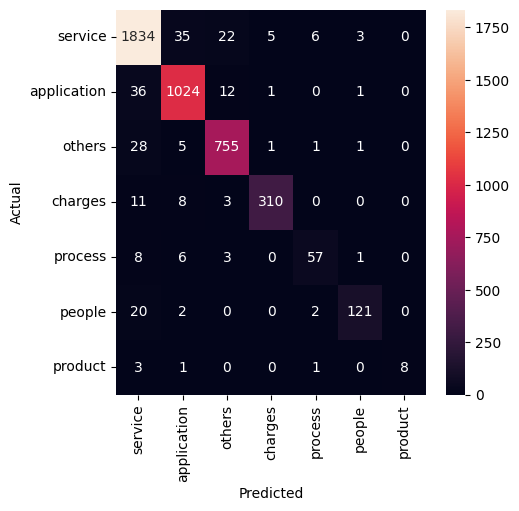

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(df_pred['category_id'], df_pred['category_id_pred'])
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.y.values, yticklabels=category_id_df.y.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Classification report overall
from sklearn import metrics
print(metrics.classification_report(df_pred['category_id'], df_pred['category_id_pred'], target_names=df['y'].unique()))

              precision    recall  f1-score   support

     service       0.95      0.96      0.95      1905
 application       0.95      0.95      0.95      1074
      others       0.95      0.95      0.95       791
     charges       0.98      0.93      0.96       332
     process       0.85      0.76      0.80        75
      people       0.95      0.83      0.89       145
     product       1.00      0.62      0.76        13

    accuracy                           0.95      4335
   macro avg       0.95      0.86      0.90      4335
weighted avg       0.95      0.95      0.95      4335



In [ ]:
res = pd.DataFrame()
# To manually verify why some failed
from IPython.display import display

for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 10:
            # print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            temp = df_pred.query(f' (category_id == {actual}) & (category_id_pred == {predicted})')[['x']]
            temp['y'] = id_to_category[actual]
            temp['y_pred'] = id_to_category[predicted]
            # print('')
            res = pd.concat([res,temp])

In [ ]:
from google.colab import data_table
data_table.DataTable(res, include_index=False, num_rows_per_page=10)

,x,y,y_pred
205,i like to start my trading so please request y...,application,service
207,no position reflects on screen near about mini...,application,service
213,i am getting very bad experience with your tra...,application,service
765,you guys have looted my money because of your ...,application,service
832,please improve traffic related issue there is ...,application,service
...,...,...,...
3075,portfolio issue stocktrident shares transactions,application,others
3465,graph not updating,application,others
3650,improvement in portal,application,others
3705,mene apne bank se kotak security me transfar d...,application,others


In [ ]:
from google.colab import data_table
data_table.DataTable(df_pred.query(' y != y_pred')[['x','y', 'y_pred']], include_index=False, num_rows_per_page=10)

,x,y,y_pred
205,i like to start my trading so please request y...,application,service
207,no position reflects on screen near about mini...,application,service
213,i am getting very bad experience with your tra...,application,service
228,your app is not trustworthy customer care numb...,service,application
254,kotak neo app is pathetic it has stopped worki...,service,application
...,...,...,...
4286,very heavy and unreasonable penalty applied on...,application,service
4289,charges are high app is not slick,charges,application
4307,hidden chargesxare exorbitantcharges,charges,others
4316,get ur act right before you turn irrelevant,service,others
